In [46]:
''' put SD-1042 and buoy 42022 (C12) on the same temporal grid & compare the difference and correlation between buoy and SD-1042
    According to COMPS website of this specific period, ADCP current velcoity data 
    (1) Measurements are collected on the hour (timestamp at :57 for sample at the top of the next hour) and 
        consist of 6 minute averages of 1 second samples, with the averages centered on the hour.
    (2) the first bin is 3.8 m.
'''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import cftime
import sys
import re
from scipy.stats import pearsonr, normaltest, kurtosistest
from numpy.linalg import norm
from metpy.calc import wind_direction
from oceans.ocfis import spdir2uv
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from convert_dir import vector_dir_to_from
from bipolar import bipolar
from mystats import lpass_NaN
from values_to_colors import categorical_cmap

In [47]:
year = '2023'
buoy_id = '42022'
path_data = '/Users/chi/Documents/Data/NDBC/'
platf_num = '1042'
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
tlim_plot = [datetime.datetime(int(year),10,19,12), datetime.datetime(int(year),11,17)] ### 2023 SD1042 within a few km from 42022
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]

In [48]:
##### compare current data #####
### buoy current data info
fn_cur = 'current_ndbc'+buoy_id+'_y'+year+'.txt'
### Read buoy current data
nline_header = 2 ### need to check lines of headers manually
with open(path_data+fn_cur, 'r') as f:
    nrow = len(f.readlines())
    print('Total Number of lines in the current data file:', nrow)
### get the headers & number of items in the header
count = 0
print('The caveat is that the file does not have exact same number of items in the header as in the data...')
with open(path_data+fn_cur, 'r') as f:
    for line in f:
        if count == nline_header:
            line_1 = re.sub(r"\s+",',',line) ### replace space(s) with ','
            if line_1[-1] == ',':
                line_1 = line_1[:-1]
            break
        count = count + 1
### read through the file
line_1_list = line_1.split(',')
ncol = len(line_1_list) # number of items in the first line of data
arrayCur = np.nan*np.ones( (nrow-nline_header,ncol) ) ### record values only
count = 0
with open(path_data+fn_cur) as f:
    for line in f:
        count = count + 1
        line_1 = re.sub(r"\s+",',',line)
        if line_1[-1] == ',':
                line_1 = line_1[:-1]
        # print(line_1)
        if count > nline_header:
            temp = line_1.split(',')
            temp = [float(item) for item in temp]
            nitem = len(temp)
            arrayCur[count-nline_header-1,0:nitem] = np.array(temp)
        
print('Shape of arrayCur:',arrayCur.shape)
arrayCur[arrayCur == 999] = np.nan

### convert to datetime
dtime_cur_buoy = []
dtime_adjust = datetime.timedelta(minutes=3)
for i in range( arrayCur.shape[0] ):
    dtime_cur_buoy.append( datetime.datetime(int(arrayCur[i,0]),int(arrayCur[i,1]),int(arrayCur[i,2]),int(arrayCur[i,3]),int(arrayCur[i,4]))+dtime_adjust )
dtime_cur_buoy = np.array( dtime_cur_buoy )
print('Buoy time:',dtime_cur_buoy[:3],dtime_cur_buoy[-1])

### depths of current
depths_cur_buoy = arrayCur[0,5:-1:3]
dz_adjust = depths_cur_buoy[-1]-3.8 # m
depths_cur_buoy = depths_cur_buoy-dz_adjust
print('Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters:', depths_cur_buoy)

### compute u & v current velocity from speed (cm/s) and direction (flowing toward) from the current data
uCur_buoy = np.nan*np.ones( (arrayCur.shape[0],len(depths_cur_buoy)) )
vCur_buoy = uCur_buoy.copy()
i0dep = 5
i0dir = 6
i0spd = 7
for i in range( uCur_buoy.shape[0] ): ### time dimension
    for z in range( len(depths_cur_buoy) ): ### depth dimension
        spd_item = arrayCur[i,i0spd+z*3]
        dir_to_item = arrayCur[i,i0dir+z*3] # direction flowing toward
        dir_from_item = (dir_to_item+180)%360
        # print(spd_item, dir_from_item, dir_to_item)
        uCur_buoy[i,z], vCur_buoy[i,z] = spdir2uv( spd_item,dir_to_item,deg=True )

Total Number of lines in the current data file: 6977
The caveat is that the file does not have exact same number of items in the header as in the data...
Shape of arrayCur: (6975, 125)
Buoy time: [datetime.datetime(2023, 1, 1, 1, 0) datetime.datetime(2023, 1, 1, 2, 0)
 datetime.datetime(2023, 1, 1, 3, 0)] 2024-01-01 00:00:00
Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters: [42.8 41.8 40.8 39.8 38.8 37.8 36.8 35.8 34.8 33.8 32.8 31.8 30.8 29.8
 28.8 27.8 26.8 25.8 24.8 23.8 22.8 21.8 20.8 19.8 18.8 17.8 16.8 15.8
 14.8 13.8 12.8 11.8 10.8  9.8  8.8  7.8  6.8  5.8  4.8  3.8]


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_28007/2374280092.py:65: RuntimeWarning: invalid value encountered in double_scalars
  dir_from_item = (dir_to_item+180)%360


<Figure size 432x288 with 0 Axes>

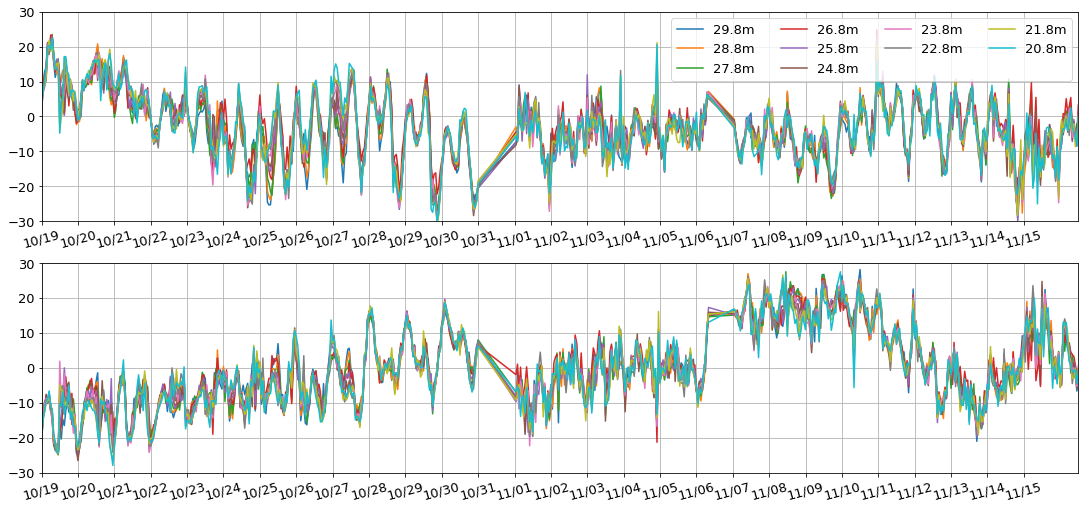

In [49]:
### check the buoy depths with noises due to inteferences with the in-line CTD instruments. 
depth_check = [20,30] # m
iz_buoy = np.where( (depths_cur_buoy>= depth_check[0]) & (depths_cur_buoy<= depth_check[1]) )[0] ### depth indice to plot
### plot
nrow = 2
plt.clf()
fig, ax = plt.subplots(nrows=nrow)
plt.gcf().set_size_inches(18, 8)
plt.rcParams.update({'font.size': 13})
for v in range( nrow ):
    for i, iz in enumerate( iz_buoy ):
        if v == 0:
            plt.subplot(nrow,1,v+1)
            plt.plot( dtime_cur_buoy, uCur_buoy[:,iz],lw=1.5,label='{:.1f}m'.format(depths_cur_buoy[iz]))
            plt.ylim([-30,30])
        else:
            plt.subplot(nrow,1,v+1)
            plt.plot( dtime_cur_buoy, vCur_buoy[:,iz],lw=1.5,label='{:.1f}m'.format(depths_cur_buoy[iz]))
            plt.ylim([-30,30])
    plt.subplot(nrow,1,v+1)
    plt.xticks(tticks,rotation=15)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    if v == 0:
        plt.legend(loc='best',ncol=4)
    plt.grid()
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.2)

iz_mask: bin [16, 24, 25]  at depths: [26.8 18.8 17.8]
buoy depth indices updated to: [13 14 15 17 18 19 20 21 22] after removing the flagged depths at bins: [16, 24, 25]


<Figure size 432x288 with 0 Axes>

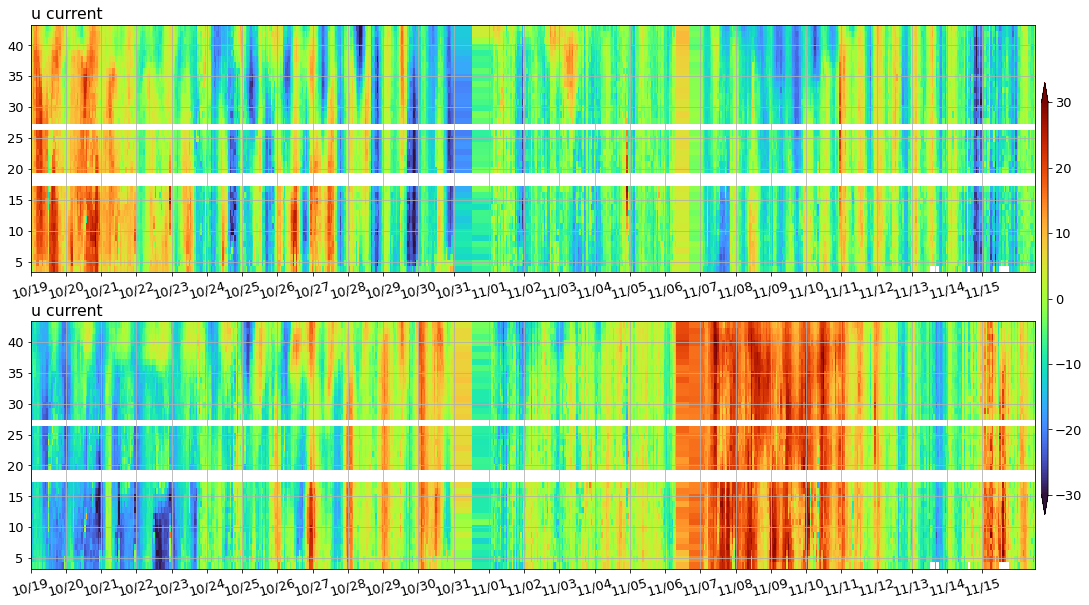

In [50]:
### plot pcolormesh time-depth plot and blow up 20-40 m to FIND OUT THE NOISY BIN BETWEEN 20-40 m. 
depth_check = [20,30] # m
iz_buoy = np.where( (depths_cur_buoy>= depth_check[0]) & (depths_cur_buoy<= depth_check[1]) )[0] ### depth indice to plot
z_mask = [17.8,18.8,26.8]
iz_mask = []
for i, z in enumerate( depths_cur_buoy ):
    if z in z_mask:
        iz_mask.append(i)
print('iz_mask: bin',iz_mask,' at depths:',depths_cur_buoy[iz_mask])
iz_buoy = np.array([value for value in iz_buoy if value not in iz_mask])
print('buoy depth indices updated to:',iz_buoy,'after removing the flagged depths at bins:',iz_mask)
vellim = [-30,30]
cmap = 'turbo'#bipolar(neutral=0.95)
nrow = 2
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 10)
plt.rcParams.update({'font.size': 13})
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    if i == 0:
        var_plot = uCur_buoy.copy()
    else:
        var_plot = vCur_buoy.copy()
    var_plot[:,iz_mask] = np.nan
    cs = plt.pcolormesh(dtime_cur_buoy, depths_cur_buoy, var_plot.transpose(),label='u',cmap=cmap,vmin=vellim[0],vmax=vellim[1])
    ### settings
    plt.xticks(tticks,rotation=15)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.title('u current',loc='left')
    plt.grid()
### add colorbar
cbar_ax = fig.add_axes([.905,.2,.005,.6])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')

In [51]:
### SD-1042 merged nc file info
### load adcp data
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_adcp.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
uCur_SD = ds_adcp.variables['vel_east'][:]*100 # cm/s
vCur_SD = ds_adcp.variables['vel_north'][:]*100
depths_cur_SD = ds_adcp.variables['depth'][:] # the shallowest depth should be ~6m. 
depths_cur_SD = depths_cur_SD+1.8
data_flag = ds_adcp.variables['data_flag'][:]
print('Depths of SD:',depths_cur_SD)
### apply nan to flagged values
uCur_SD[data_flag > 0] = np.nan
vCur_SD[data_flag > 0] = np.nan

Depths of SD: [  6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.
  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.
  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.
  90.  92.  94.  96.  98. 100. 102. 104.]


In [66]:
### Directly compare the depth-averaged "6-minute" moored buoy (C12) recored hourly to 5-min SD-1042
depth_check = [20,40] # m
iz_buoy = np.where( (depths_cur_buoy>= depth_check[0]) & (depths_cur_buoy<= depth_check[1]) )[0] ### depth indice to plot
iz_SD = np.where( (depths_cur_SD>= depth_check[0]) & (depths_cur_SD<= depth_check[1]) )[0]
print('Look at current(buoy) at {:.1f}-{:.1f}m: '.format(depths_cur_buoy[iz_buoy][0], depths_cur_buoy[iz_buoy][-1]), depths_cur_buoy[iz_buoy]) 
print('Look at current (SD) at {:.1f}-{:.1f}m: '.format(depths_cur_SD[iz_SD][0], depths_cur_SD[iz_SD][-1]),depths_cur_SD[iz_SD])
###
timestamp_cur_SD = np.array([dtime_cur_SD[i].timestamp() for i in range( len(dtime_cur_SD) )])
timestamp_cur_buoy = np.array([dtime_cur_buoy[i].timestamp() for i in range( len(dtime_cur_buoy) )])
ucur_SD_common = np.nan*np.ones( timestamp_cur_buoy.shape )
vcur_SD_common = ucur_SD_common.copy()
### put current velocity from both SD & buoy to the common temporal grid (buoy's grid). Only retain depths that 
dtime_cur_common = dtime_cur_buoy.copy()
ucur_buoy_common = np.nanmean( uCur_buoy[:,iz_buoy],axis=1 )
vcur_buoy_common = np.nanmean( vCur_buoy[:,iz_buoy],axis=1 )
for i in range( len(dtime_cur_buoy) ):
    tlim = [dtime_cur_buoy[i], dtime_cur_buoy[i]+datetime.timedelta(minutes=6)]
    itacq_in_SD = np.where( (dtime_cur_SD>=tlim[0]) & (dtime_cur_SD<= tlim[1]) )[0]
    # itacq_in_SD = np.where( np.abs(timestamp_cur_SD-timestamp_cur_buoy[i])<= 180 )[0]
    if len(itacq_in_SD) > 0:
        ucur_SD_common[i] = np.nanmean( uCur_SD[np.ix_(itacq_in_SD,iz_SD)].flatten() )
        vcur_SD_common[i] = np.nanmean( vCur_SD[np.ix_(itacq_in_SD,iz_SD)].flatten() )
print('ucur on common grid: buoy=',ucur_buoy_common.shape, '. SD=',ucur_SD_common.shape)

### compute vector direction from
cur_dir_from_buoy_common = np.nan*np.ones( ucur_buoy_common.shape )
cur_dir_from_SD_common = np.nan*np.ones( ucur_SD_common.shape )
for i in range( len(dtime_cur_common) ):
    _, cur_dir_from_buoy_common[i] = vector_dir_to_from(ucur_buoy_common[i],vcur_buoy_common[i])
    _, cur_dir_from_SD_common[i] = vector_dir_to_from(ucur_SD_common[i],vcur_SD_common[i])

### slice according to the tlim_plot 
it_comp = np.where( (dtime_cur_common>= tlim_plot[0]) & (dtime_cur_common< tlim_plot[1]) )[0]
dtime_cur_common = dtime_cur_common[it_comp]
ucur_SD_common = ucur_SD_common[it_comp]
vcur_SD_common = vcur_SD_common[it_comp]
ucur_buoy_common = ucur_buoy_common[it_comp]
vcur_buoy_common = vcur_buoy_common[it_comp]
cur_dir_from_SD_common = cur_dir_from_SD_common[it_comp]
cur_dir_from_buoy_common = cur_dir_from_buoy_common[it_comp]

Look at current(buoy) at 39.8-20.8m:  [39.8 38.8 37.8 36.8 35.8 34.8 33.8 32.8 31.8 30.8 29.8 28.8 27.8 26.8
 25.8 24.8 23.8 22.8 21.8 20.8]
Look at current (SD) at 20.0-40.0m:  [20. 22. 24. 26. 28. 30. 32. 34. 36. 38. 40.]


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_28007/4095545520.py:14: RuntimeWarning: Mean of empty slice
  ucur_buoy_common = np.nanmean( uCur_buoy[:,iz_buoy],axis=1 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_28007/4095545520.py:15: RuntimeWarning: Mean of empty slice
  vcur_buoy_common = np.nanmean( vCur_buoy[:,iz_buoy],axis=1 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_28007/4095545520.py:21: RuntimeWarning: Mean of empty slice
  ucur_SD_common[i] = np.nanmean( uCur_SD[np.ix_(itacq_in_SD,iz_SD)].flatten() )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_28007/4095545520.py:22: RuntimeWarning: Mean of empty slice
  vcur_SD_common[i] = np.nanmean( vCur_SD[np.ix_(itacq_in_SD,iz_SD)].flatten() )


ucur on common grid: buoy= (6975,) . SD= (6975,)


609


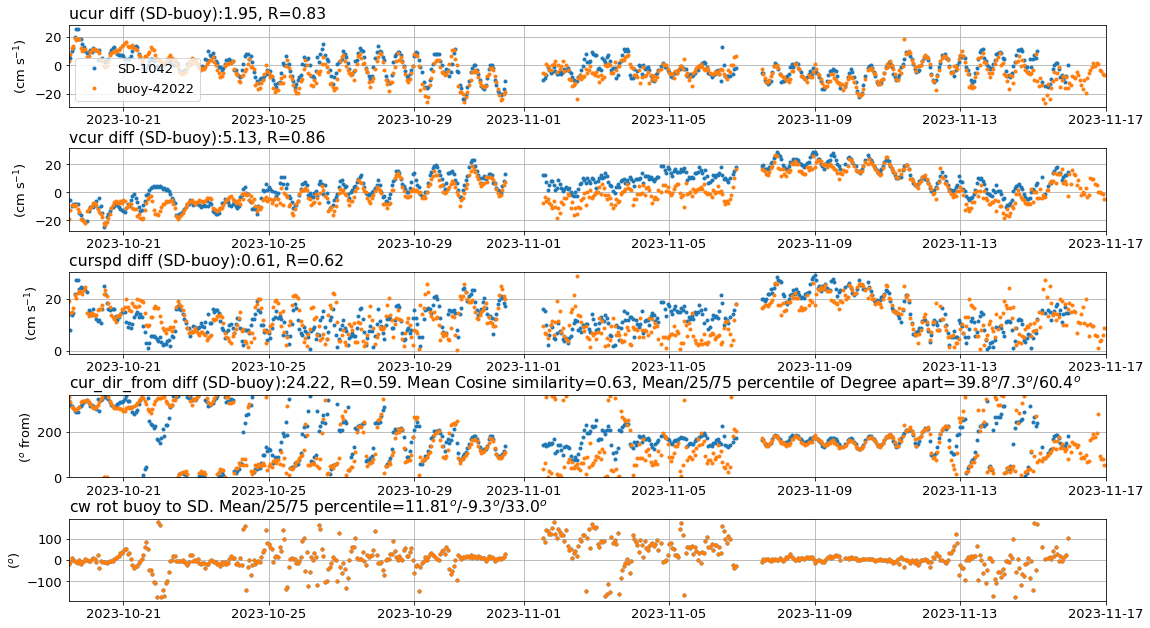

In [67]:
### compute current speed
curspd_SD_common = np.sqrt( np.square(ucur_SD_common) + np.square(vcur_SD_common) )
curspd_buoy_common = np.sqrt( np.square(ucur_buoy_common) + np.square(vcur_buoy_common) )
isOK_common = ~np.isnan(ucur_SD_common) & ~np.isnan(ucur_buoy_common)
print(np.sum(isOK_common),)
### compute cosine similarity
vector_SD = np.column_stack( (ucur_SD_common,vcur_SD_common) )
vector_buoy = np.column_stack( (ucur_buoy_common,vcur_buoy_common) )
cosine_SD_buoy = np.sum(vector_SD*vector_buoy, axis=1)/(norm(vector_SD,axis=1)*norm(vector_buoy,axis=1))
deg_apart_btw_SD_buoy = np.nan*np.ones(cosine_SD_buoy.shape)
for i in range( len(cosine_SD_buoy) ):
    deg_apart_btw_SD_buoy[i] = math.degrees( math.acos(cosine_SD_buoy[i]) ) # convert radians to degree
perc = [25,75]
deg_apart_perc = np.percentile(deg_apart_btw_SD_buoy[isOK_common],perc)
### compute degree from buoy dir to SD dir (positive clockwise)
deg_cur_buoy2SD_clockwise = (cur_dir_from_SD_common-cur_dir_from_buoy_common)
deg_cur_buoy2SD_clockwise[deg_cur_buoy2SD_clockwise> 180] = deg_cur_buoy2SD_clockwise[deg_cur_buoy2SD_clockwise> 180]-360
deg_cur_buoy2SD_clockwise[deg_cur_buoy2SD_clockwise< -180] = deg_cur_buoy2SD_clockwise[deg_cur_buoy2SD_clockwise< -180]+360
deg_cur_buoy2SD_perc = np.percentile(deg_cur_buoy2SD_clockwise[isOK_common],perc)
###
var_str = ['ucur','vcur','curspd','cur_dir_from','cw rot buoy to SD']
var_unit = ['(cm s$^{-1}$)','(cm s$^{-1}$)','(cm s$^{-1}$)','($^o$ from)','($^o$)']
nrow = len(var_str)
plt.clf()
plt.gcf().set_size_inches(18, 10)
plt.rcParams.update({'font.size': 13})
for i in range( len(var_str) ):
    plt.subplot(nrow,1,i+1)
    if i < len(var_str)-1:
        exec_str1 = 'var1 = '+var_str[i]+'_SD_common'
        exec_str2 = 'var2 = '+var_str[i]+'_buoy_common'
    else:
        exec_str1 = 'var1 = deg_cur_buoy2SD_clockwise'
        exec_str2 = 'var2 = deg_cur_buoy2SD_clockwise'
    exec(exec_str1)
    exec(exec_str2)
    plt.plot( dtime_cur_common, var1,'.',label='SD-'+platf_num )
    plt.plot( dtime_cur_common, var2,'.',label='buoy-'+buoy_id )
    if i < len(var_str)-1:
        r = np.corrcoef(var1[isOK_common], var2[isOK_common])
        mn = np.mean(var1[isOK_common]-var2[isOK_common])
    # print(var_str[i]+' diff (SD({:.1f}m)-buoy({:.1f}m)):{:.2f}'.format(depths_cur_SD[iz_SD],depths_cur_buoy[iz_buoy],mn), 'R={:.2f}'.format(r[0][1]))
    ### print stats on title
    if i < 3:
        plt.title(var_str[i]+' diff (SD-buoy):{:.2f}, R={:.2f}'.format(mn,r[0][1]),loc='left')
    elif i == 3:
        plt.title(var_str[i]+' diff (SD-buoy):{:.2f}, R={:.2f}. Mean Cosine similarity={:.2f}, Mean/{:.0f}/{:.0f} percentile of Degree apart={:.1f}$^o$/{:.1f}$^o$/{:.1f}$^o$'.\
                  format(mn,r[0][1],np.nanmean(cosine_SD_buoy),perc[0],perc[1],np.nanmean(deg_apart_btw_SD_buoy),deg_apart_perc[0],deg_apart_perc[1]),loc='left')
    else:
        plt.title(var_str[i]+'. Mean/{:.0f}/{:.0f} percentile={:.2f}$^o$/{:.1f}$^o$/{:.1f}$^o$'.\
                  format(perc[0],perc[1],np.nanmean(deg_cur_buoy2SD_clockwise),deg_cur_buoy2SD_perc[0],deg_cur_buoy2SD_perc[1]),loc='left')
    
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.grid()
    plt.xlim(tlim_plot)
    plt.ylabel(var_unit[i])
    if i == 0:
        plt.legend()
    if i == 3:
        plt.ylim([0,360])

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.5)
### save to figure
plt.savefig('timeseries_cur_dir_SD'+platf_num+'(QC)_vs_buoy'+buoy_id+'(rem-noise-depths)_zavg({:.0f}-{:.0f}m)'.format(depth_check[0],depth_check[1])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

129600.0 3600.0
corr. coef for ucurSD vs.buoy= 0.867 (p-value= 5.42E-85)
corr. coef for ucur(lp) SD vs.buoy= 0.901 (p-value= 5.43E-102)
corr. coef for vcurSD vs.buoy= 0.865 (p-value= 3.50E-84)
corr. coef for vcur(lp) SD vs.buoy= 0.959 (p-value= 6.23E-153)


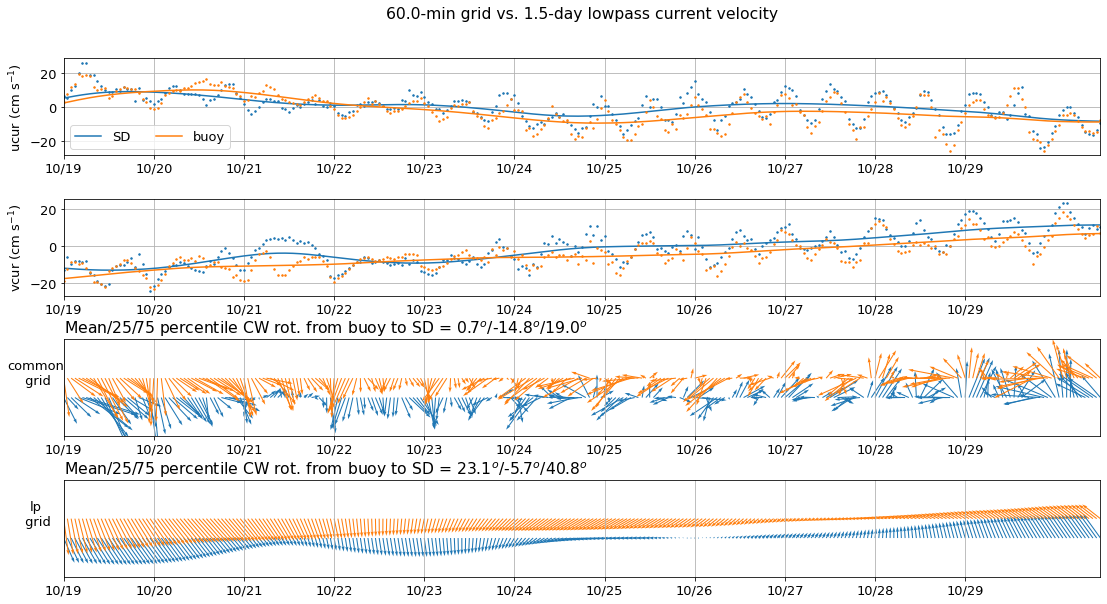

In [68]:
### low pass current data (to remove tidal signals) & re-plot the difference
tlim_lp = [datetime.datetime(int(year),10,19,12), datetime.datetime(int(year),10,31)]
nday_plot = (tlim_lp[1]-tlim_lp[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
it = np.where( (dtime_cur_common>= tlim_lp[0]) & (dtime_cur_common<= tlim_lp[1]) )[0]
###
lp_cut_day = 1.5
f_lp = 2*np.pi/(lp_cut_day*86400) # rad/sec
lp_sec = 2*np.pi/f_lp
dsec = (dtime_cur_common[1]-dtime_cur_common[0]).total_seconds()
print(lp_sec, dsec)
ucur_buoy_lp, _,_ = lpass_NaN( ucur_buoy_common[it], dsec, lp_sec, 2)
vcur_buoy_lp, _,_ = lpass_NaN( vcur_buoy_common[it], dsec, lp_sec, 2)
ucur_SD_lp, _,_ = lpass_NaN( ucur_SD_common[it], dsec, lp_sec, 2)
vcur_SD_lp, _,_ = lpass_NaN( vcur_SD_common[it], dsec, lp_sec, 2)
### compute vector direction from
cur_dir_from_buoy_lp = np.nan*np.ones( ucur_buoy_lp.shape )
cur_dir_from_SD_lp = np.nan*np.ones( ucur_SD_lp.shape )
for i in range( len(cur_dir_from_buoy_lp) ):
    _, cur_dir_from_buoy_lp[i] = vector_dir_to_from(ucur_buoy_lp[i],vcur_buoy_lp[i])
    _, cur_dir_from_SD_lp[i] = vector_dir_to_from(ucur_SD_lp[i],vcur_SD_lp[i])

### plot
nrow = 4
plt.clf()
plt.gcf().set_size_inches(18, 9)
plt.rcParams.update({'font.size': 13})
platf_col = plt.get_cmap('tab10').N
platf_str = ['SD','buoy']
var_str = ['ucur','vcur']
### plot time series
for i, var_this in enumerate( var_str ):
    plt.subplot(nrow,1,i+1)
    y_platf = np.nan*np.ones( (len(it),len(platf_str)) )
    ybp_platf = y_platf.copy()
    for j, platf in enumerate( platf_str ):
        y = eval(var_this+'_'+platf+'_common')
        y_platf[:,j] = y[it]
        plt.plot( dtime_cur_common[it], y[it],'.',ms=3,color=plt.get_cmap('tab10')(j),label='')
        ybp = eval(var_this+'_'+platf+'_lp')
        ybp_platf[:,j] = ybp[it]
        plt.plot( dtime_cur_common[it], ybp[it], color=plt.get_cmap('tab10')(j),label=platf)
    ### compute corr. coef
    isOK = (~np.isnan(y_platf[:,0]) & (~np.isnan(y_platf[:,1])))
    r = pearsonr(y_platf[isOK,0],y_platf[isOK,1])
    print('corr. coef for '+var_this+' vs.'.join(platf_str)+'= {:.3f} (p-value= {:.2E})'.format(r[0],r[1]))
    isOK = (~np.isnan(ybp_platf[:,0]) & (~np.isnan(ybp_platf[:,1])))
    r = pearsonr(ybp_platf[isOK,0],ybp_platf[isOK,1])
    print('corr. coef for '+var_this+'(lp) '+' vs.'.join(platf_str)+'= {:.3f} (p-value= {:.2E})'.format(r[0],r[1]))
    ### add corr. coef & p-value to title
    # plt.title()
    ###
    if i == 0:
        plt.legend(loc='best',ncol=2)
    plt.ylabel(var_this+' (cm s$^{-1}$)')
### plot quiver plot - hourly grid
grid_str = ['common','lp']
for i, grid_this in enumerate( grid_str ):
    plt.subplot(nrow,1,i+3)
    for j, platf in enumerate( platf_str ):
        plt.quiver(dtime_cur_common[it],j*np.ones(it.shape),eval('ucur_'+platf+'_'+grid_this)[it],eval('vcur_'+platf+'_'+grid_this)[it],\
                scale=500,width=0.001,color=plt.get_cmap('tab10')(j))
    # compute degree from buoy dir to SD dir (positive clockwise)
    deg_cur_buoy2SD_cw = (eval('cur_dir_from_SD_'+grid_this)[it]-eval('cur_dir_from_buoy_'+grid_this)[it])
    deg_cur_buoy2SD_cw[deg_cur_buoy2SD_cw> 180] = deg_cur_buoy2SD_cw[deg_cur_buoy2SD_cw> 180]-360
    deg_cur_buoy2SD_cw[deg_cur_buoy2SD_cw< -180] = deg_cur_buoy2SD_cw[deg_cur_buoy2SD_cw< -180]+360
    isOK = ~np.isnan(deg_cur_buoy2SD_cw)
    deg_cur_buoy2SD_perc = np.percentile(deg_cur_buoy2SD_cw[isOK],perc)
    plt.title('Mean/{:.0f}/{:.0f} percentile CW rot. from buoy to SD = {:.1f}$^o$/{:.1f}$^o$/{:.1f}$^o$'\
            .format(perc[0],perc[1],np.nanmean(deg_cur_buoy2SD_cw),deg_cur_buoy2SD_perc[0],deg_cur_buoy2SD_perc[1]),loc='left')
    plt.ylabel(grid_this+'\n grid',rotation=0,labelpad=28)
### figure settings
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.grid()
    plt.xlim(tlim_lp)
    plt.xticks(tticks,rotation=0)
    plt.gca().set_xticklabels(tticks_label)
    if i > 1:
        plt.ylim([-2,3])
        plt.yticks([])
###
plt.suptitle('{:.1f}-min grid vs. {:.1f}-day lowpass current velocity'.format(dsec/60, lp_cut_day))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.45)
### save figure
plt.savefig('timeseries_cur_quiver_SD'+platf_num+'(QC)_vs_buoy'+buoy_id+'(rem-noise-depths)_zavg({:.0f}-{:.0f}m)'.format(depth_check[0],depth_check[1])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

mean [20, 80] percentile of lp 23.147858077372824 [-10.77325431  55.18204848]
s^2+k^2=  19.75018853969604 p value=  5.144001070913473e-05
z-score of kurtosis test= 4.43 with p-value= 9.37e-06
mean [20, 80] percentile of common 0.6739681523660392 [-21.16906768  25.90003619]
s^2+k^2=  22.127761830576144 p value=  1.5668144567307113e-05
z-score of kurtosis test= 4.65 with p-value= 3.27e-06


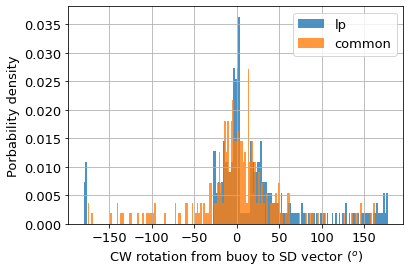

In [69]:
grid_str = ['lp','common']
perc = [20,80]
for i, grid_this in enumerate( grid_str ):
    # compute degree from buoy dir to SD dir (positive clockwise)
    deg_cur_buoy2SD_cw = (eval('cur_dir_from_SD_'+grid_this)[it]-eval('cur_dir_from_buoy_'+grid_this)[it])
    deg_cur_buoy2SD_cw[deg_cur_buoy2SD_cw> 180] = deg_cur_buoy2SD_cw[deg_cur_buoy2SD_cw> 180]-360
    deg_cur_buoy2SD_cw[deg_cur_buoy2SD_cw< -180] = deg_cur_buoy2SD_cw[deg_cur_buoy2SD_cw< -180]+360
    varlim = [np.nanmin(deg_cur_buoy2SD_cw), np.nanmax(deg_cur_buoy2SD_cw)]
    plt.hist(deg_cur_buoy2SD_cw, bins=np.arange(np.floor(varlim[0]),np.ceil(varlim[1]),2), density='True', alpha=0.8, label=grid_this)
    isOK = ~np.isnan( deg_cur_buoy2SD_cw )
    print('mean',perc,'percentile of '+grid_this,np.nanmean(deg_cur_buoy2SD_cw),np.percentile(deg_cur_buoy2SD_cw[isOK],perc))
    stats, pvalue = normaltest(deg_cur_buoy2SD_cw,nan_policy='omit')
    print('s^2+k^2= ',stats,'p value= ', pvalue)
    ''' From https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
    The normal distribution has zero skewness and zero (“excess” or “Fisher”) kurtosis, 
    the value of this statistic tends to be low for samples drawn from a normal distribution.
    The test is performed by comparing the observed value of the statistic against the null distribution: 
    the distribution of statistic values derived under the null hypothesis that the weights were drawn from a normal distribution.
    The test is performed by comparing the observed value of the statistic against the null distribution: 
    the distribution of statistic values derived under the null hypothesis that the weights were drawn from a normal distribution.
    If the p-value is “small” - that is, if there is a low probability of sampling data from a normally distributed population that produces such an extreme value of the statistic 
    - this may be taken as evidence against the null hypothesis in favor of the alternative: the weights were not drawn from a normal distribution.
    '''
    stats, pvalue = kurtosistest(deg_cur_buoy2SD_cw,nan_policy='omit')
    print('z-score of kurtosis test= {:.2f} with p-value= {:.2e}'.format(stats,pvalue))
plt.legend(loc='best')
plt.grid()
plt.ylabel('Porbability density')
plt.xlabel('CW rotation from buoy to SD vector ($^o$)');
### save figure
plt.savefig('pdf_CW-rot_cur_dir_from_buoy'+buoy_id+'(rem-noise-depths)-to-SD'+platf_num+'(QC)_zavg({:.0f}-{:.0f}m)'.format(depth_check[0],depth_check[1])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')